In [ ]:
!pip install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

!pip install qdrant-client
!pip install Pillow


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --yes
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-pnhv5lzy
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-pnhv5lzy
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=7d541c7344d5dece798c7b093ed28dd8e96b0634a3c4c6c7029af8e33e6f75b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-yfmwl8l3/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d113

In [ ]:
import torch
import clip
from PIL import Image
import numpy as np
import os
import re
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import Distance, VectorParams
from tqdm import tqdm
import uuid
from torch.utils.data import Dataset, DataLoader


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, preprocess = clip.load('ViT-B/32', device=device)

print(f"CLIP model loaded on {device}")
print(f"Number of dimension: {model.visual.output_dim}")


CLIP model loaded on cpu
Number of dimension: 512


Nếu đã lưu embedding, chuyển xuống bước load embeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def parse_keyframe_filename(filename):
    name_without_ext = os.path.splitext(filename)[0]

    pattern = r'^(.+)_(.+)_(\d+)m(\d+)s$'
    match = re.match(pattern, name_without_ext)

    if match:
        video_type = match.group(1)
        video_name = match.group(2)
        minutes = int(match.group(3))
        seconds = int(match.group(4))
        total_seconds = minutes * 60 + seconds

        return {
            'type': video_type,
            'video_name': video_name,
            'minutes': minutes,
            'seconds': seconds,
            'total_seconds': total_seconds,
            'filename': filename,
            'timestamp': f"{minutes}:{seconds:02d}"  # giờ ok
        }
    else:
        print(f"Không parse được: {filename}")
        return None

Total keyframe: 180
L27_V001_00m21s.jpg |||{'type': 'L27', 'video_name': 'V001', 'minutes': '00', 'seconds': '21'}
L27_V001_00m22s.jpg |||{'type': 'L27', 'video_name': 'V001', 'minutes': '00', 'seconds': '22'}
L27_V001_00m23s.jpg |||{'type': 'L27', 'video_name': 'V001', 'minutes': '00', 'seconds': '23'}
L27_V001_00m24s.jpg |||{'type': 'L27', 'video_name': 'V001', 'minutes': '00', 'seconds': '24'}
L27_V001_00m25s.jpg |||{'type': 'L27', 'video_name': 'V001', 'minutes': '00', 'seconds': '25'}
L27_V001_00m26s.jpg |||{'type': 'L27', 'video_name': 'V001', 'minutes': '00', 'seconds': '26'}
L27_V001_00m27s.jpg |||{'type': 'L27', 'video_name': 'V001', 'minutes': '00', 'seconds': '27'}
L27_V001_00m28s.jpg |||{'type': 'L27', 'video_name': 'V001', 'minutes': '00', 'seconds': '28'}
L27_V001_00m31s.jpg |||{'type': 'L27', 'video_name': 'V001', 'minutes': '00', 'seconds': '31'}
L27_V001_00m32s.jpg |||{'type': 'L27', 'video_name': 'V001', 'minutes': '00', 'seconds': '32'}


In [ ]:
client = QdrantClient(':memory:')

collection_name = 'video_keyframes'

client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=512, distance=Distance.COSINE)
)

print(f"Đã tạo collection: {collection_name}")




Đã tạo collection: video_keyframes


UPLOAD FRAME INTO DATABASE
Khởi tạo Database khi lần đầu chạy, ở các lần sau bỏ qua bước này, chuyển đến (Load lại Collection)

In [ ]:
class KeyFrameDataset(Dataset):
  def __init__(self, keyframe_folder, transform, parse_fn):
    self.keyframe_folder = keyframe_folder
    self.transform = transform
    self.parse_fn = parse_fn
    self.files = [f for f in os.listdir(keyframe_folder) if f.endswith(('.jpg', '.jpeg', '.png', '.tiff'))]

  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    filename = self.files[index]
    metadata = self.parse_fn(filename)
    if not metadata:
      return None

    img_path = os.path.join(self.keyframe_folder, filename)
    image = Image.open(img_path).convert('RGB')
    image_input = self.transform(image)

    metadata['file_path'] = img_path
    return image_input, metadata

In [ ]:
def process_and_upload_keyframes(keyframe_folder, batch_size=32, num_workers=4):
  dataset = KeyFrameDataset(keyframe_folder, preprocess, parse_keyframe_filename)
  dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers,
                          shuffle=False, collate_fn=lambda x: [y for y in x if y is not None])


  # all_files = [f for f in os.listdir(keyframe_folder) if f.endswith(('.jpg', '.jpeg', '.png', '.tiff'))]

  print(f'Tổng dữ liệu cần xử lý: {len(dataset)}')

  points = []
  failed_count = 0

  for batch in tqdm(dataloader, desc="Processing batches"):
    try:
        batch_images, batch_metadata = zip(*batch)
        batch_tensor = torch.stack(batch_images).to(device)

        with torch.no_grad():
            embeddings = model.encode_image(batch_tensor)
            embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)
            embeddings = embeddings.cpu().numpy()

            for embedding, metadata in zip(embeddings, batch_metadata):
                point = models.PointStruct(
                    id=abs(hash(f"{metadata['video_name']}_{metadata['timestamp']}")) % (10**12),
                    vector=embedding.tolist(),
                    payload=metadata
                )
                points.append(point)

    except Exception as e:
        print(f"Lỗi batch: {e}")
        failed_count += len(batch)
        continue

  if points:
      print(f"\nUploading {len(points)} points vào Qdrant")
      client.upsert(
          collection_name=collection_name,
          points=points
      )
      print("Upload hoàn thành")

  return len(points), failed_count

In [ ]:
keyframe_folder = '/content/drive/MyDrive/DatasetKeyFrame'

for i, keyframe_subfolder in enumerate(os.listdir(keyframe_folder), 1):
    subfolder_path = os.path.join(keyframe_folder, keyframe_subfolder)

    if not os.path.isdir(subfolder_path):
        continue

    print(f"\n=== Folder {i}: {keyframe_subfolder} ===")
    success_count, failed_count = process_and_upload_keyframes(subfolder_path)
    print(f"Tổng số điểm thành công: {success_count}")
    print(f"Tổng số điểm thất bại: {failed_count}")
    print(f"Đang trong folder {subfolder_path}")


=== Folder 1: V004 ===
Tổng dữ liệu cần xử lý: 186


Processing batches: 100%|██████████| 6/6 [00:25<00:00,  4.27s/it]



Uploading 186 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 186
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V004

=== Folder 2: V002 ===
Tổng dữ liệu cần xử lý: 219


Processing batches: 100%|██████████| 7/7 [00:32<00:00,  4.61s/it]



Uploading 219 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 219
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V002

=== Folder 3: V005 ===
Tổng dữ liệu cần xử lý: 209


Processing batches: 100%|██████████| 7/7 [00:47<00:00,  6.76s/it]



Uploading 209 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 209
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V005

=== Folder 4: V006 ===
Tổng dữ liệu cần xử lý: 177


Processing batches: 100%|██████████| 6/6 [00:40<00:00,  6.80s/it]



Uploading 177 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 177
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V006

=== Folder 5: V001 ===
Tổng dữ liệu cần xử lý: 180


Processing batches: 100%|██████████| 6/6 [00:35<00:00,  6.00s/it]



Uploading 180 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 180
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V001

=== Folder 6: V009 ===
Tổng dữ liệu cần xử lý: 182


Processing batches: 100%|██████████| 6/6 [00:36<00:00,  6.12s/it]



Uploading 182 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 182
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V009

=== Folder 7: V003 ===
Tổng dữ liệu cần xử lý: 177


Processing batches: 100%|██████████| 6/6 [00:35<00:00,  5.86s/it]



Uploading 177 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 177
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V003

=== Folder 8: V008 ===
Tổng dữ liệu cần xử lý: 190


Processing batches: 100%|██████████| 6/6 [00:37<00:00,  6.31s/it]



Uploading 190 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 190
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V008

=== Folder 9: V010 ===
Tổng dữ liệu cần xử lý: 200


Processing batches: 100%|██████████| 7/7 [00:42<00:00,  6.01s/it]



Uploading 200 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 200
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V010

=== Folder 10: V007 ===
Tổng dữ liệu cần xử lý: 230


Processing batches: 100%|██████████| 8/8 [00:33<00:00,  4.15s/it]



Uploading 230 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 230
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V007

=== Folder 11: V013 ===
Tổng dữ liệu cần xử lý: 256


Processing batches: 100%|██████████| 8/8 [00:47<00:00,  5.88s/it]



Uploading 256 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 256
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V013

=== Folder 12: V015 ===
Tổng dữ liệu cần xử lý: 243


Processing batches: 100%|██████████| 8/8 [00:46<00:00,  5.76s/it]



Uploading 243 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 243
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V015

=== Folder 13: V016 ===
Tổng dữ liệu cần xử lý: 193


Processing batches: 100%|██████████| 7/7 [00:39<00:00,  5.69s/it]



Uploading 193 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 193
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V016

=== Folder 14: V012 ===
Tổng dữ liệu cần xử lý: 222


Processing batches: 100%|██████████| 7/7 [00:48<00:00,  6.95s/it]



Uploading 222 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 222
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V012

=== Folder 15: V011 ===
Tổng dữ liệu cần xử lý: 239


Processing batches: 100%|██████████| 8/8 [00:45<00:00,  5.75s/it]



Uploading 239 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 239
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V011

=== Folder 16: V014 ===
Tổng dữ liệu cần xử lý: 186


Processing batches: 100%|██████████| 6/6 [00:40<00:00,  6.68s/it]


Uploading 186 points vào Qdrant
Upload hoàn thành
Tổng số điểm thành công: 186
Tổng số điểm thất bại: 0
Đang trong folder /content/drive/MyDrive/DatasetKeyFrame/V014


Lưu lại Collection khi lần đầu chạy, lần sau bỏ qua bước này load bước tiếp theo

In [ ]:
import pickle

def save_all_embeddings_batched(save_path, batch_size=1000):
  all_vectors = []
  all_payloads = []
  next_page_offset = None
  total_processed = 0

  while True:
    points, next_page_offset = client.scroll(
        collection_name=collection_name,
        limit=batch_size,
        offset=next_page_offset,
        with_vectors=True,
        with_payload=True
    )

    if not points:
      break

    for point in points:
      all_vectors.append(point.vector)
      all_payloads.append(point.payload)

    total_processed += len(points)
    print(f"Processed {total_processed} points")

    if next_page_offset is None:
      break

  embeddings_data = {
      'vectors': all_vectors,
      'payloads': all_payloads
  }

  with open(save_path, 'wb') as f:
    pickle.dump(embeddings_data, f)

  file_size = os.path.getsize(save_path)
  print(f"Lưu TOÀN BỘ {len(all_vectors)} embeddings ({file_size:.2f} MB)")
  return len(all_vectors)


def save_embeddings_smart(save_path):
  collection_info = client.get_collection(collection_name)
  total_points = collection_info.points_count

  print(f"Collection có {total_points} points")

  if total_points <= 50000:
    print("Lấy tất cả trong 1 lần")
    all_points, _ = client.scroll(
        collection_name=collection_name,
        limit=total_points + 100,
        with_payload=True,
        with_vectors=True
    )

    embeddings_data = {
        'vectors': [point.vector for point in all_points],
        'payloads': [point.payload for point in all_points]
    }

  else:
    print("Lấy theo batch")
    return save_all_embeddings_batched(save_path)


  with open(save_path, 'wb') as f:
    pickle.dump(embeddings_data, f)

  file_size = os.path.getsize(save_path) / (1024 * 1024)
  actual_saved = len(embeddings_data['vectors'])

  print(f"✅ Lưu {actual_saved}/{total_points} embeddings ({file_size:.2f} MB)")

  if actual_saved < total_points:
      print(f"⚠️  Thiếu {total_points - actual_saved} points! Thử cách 2 (batched)")

  return actual_saved


# Lưu COLLECTION
count = save_embeddings_smart("/content/drive/MyDrive/video_embeddings_ALL.pkl")

Collection có 3289 points
Lấy tất cả trong 1 lần
✅ Lưu 3289/3289 embeddings (15.13 MB)


In [ ]:
def verify_saved_data(saved_file):
    with open(saved_file, 'rb') as f:
        data = pickle.load(f)

    collection_info = client.get_collection(collection_name)
    total_in_db = collection_info.points_count
    total_in_file = len(data['vectors'])

    print(f"📊 Verification:")
    print(f"   In database: {total_in_db}")
    print(f"   In saved file: {total_in_file}")
    print(f"   Match: {'✅ Yes' if total_in_db == total_in_file else '❌ No'}")

verify_saved_data("/content/drive/MyDrive/video_embeddings_ALL.pkl")

📊 Verification:
   In database: 3289
   In saved file: 3289
   Match: ✅ Yes


LOAD EMBEDDINGS

In [ ]:
def quick_setup_video_search():

    print("🚀 Quick setup Video Search System...")

    # 1. Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Mounted Google Drive")

    # 2. Install packages (nếu cần)
    import subprocess
    import sys

    packages = ['git+https://github.com/openai/CLIP.git', 'qdrant-client']
    for package in packages:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '-q'])
    print("✅ Installed packages")

    # 3. Load CLIP
    import torch
    import clip
    global device, model, preprocess
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    print(f"✅ CLIP loaded on {device}")

    # 4. Setup Qdrant
    from qdrant_client import QdrantClient
    from qdrant_client.http.models import Distance, VectorParams, PointStruct

    global client, collection_name
    client = QdrantClient(":memory:")
    collection_name = 'video_keyframes'

    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=512, distance=Distance.COSINE)
    )
    print("✅ Created Qdrant collection")

    # 5. Load embeddings từ file (NHANH!)
    embeddings_path = "/content/drive/MyDrive/video_embeddings_ALL.pkl"

    if os.path.exists(embeddings_path):
        import pickle
        with open(embeddings_path, 'rb') as f:
            data = pickle.load(f)

        # Upload vào Qdrant
        points = []
        for i, (vector, payload) in enumerate(zip(data['vectors'], data['payloads'])):
            unique_id = abs(hash(f"{payload['video_name']}_{payload['timestamp']}")) % (10**12)
            point = PointStruct(
                id=unique_id,
                vector=vector,
                payload=payload
            )
            points.append(point)

        client.upsert(collection_name=collection_name, points=points)
        print(f"✅ Loaded {len(points)} keyframes embeddings")
    else:
        print("❌ Embeddings file not found! Cần tạo lại database.")

    print("🎉 Setup hoàn tất! Sẵn sàng search.")
    return True


quick_setup_video_search()

🚀 Quick setup Video Search System...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Mounted Google Drive
✅ Installed packages
✅ CLIP loaded on cpu
✅ Created Qdrant collection
✅ Loaded 3289 keyframes embeddings
🎉 Setup hoàn tất! Sẵn sàng search.


True

QUERY DATASET

In [ ]:
def search_keyframes(query_text, top_k=5):
  text_tokens = clip.tokenize([query_text]).to(device)

  with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    query_vector = text_features.cpu().numpy()[0].tolist()


  search_result = client.search(
      collection_name=collection_name,
      query_vector=query_vector,
      limit=top_k
  )

  res = []
  for hit in search_result:
    payload = hit.payload
    res.append({
        'type': payload['type'],
        'video_name': payload['video_name'],
        'minutes': payload['minutes'],
        'seconds': payload['seconds'],
        'timestamp': payload['timestamp'],
        'score': hit.score,
        'filename': payload['filename'],
    })

  return res


Test Query


🔍 Query: 'The man eat soup by the spoon'
Test
1. Video: L27_V016 | Time: 8:03 | Score: 0.301 | File: L27_V016_08m03s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V016


/tmp/ipython-input-1574166329.py:10: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


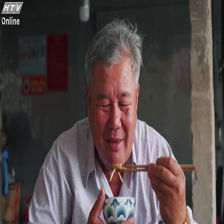

2. Video: L27_V001 | Time: 0:44 | Score: 0.299 | File: L27_V001_00m44s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V001


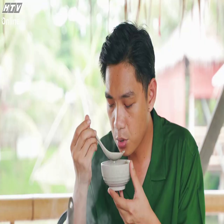

3. Video: L27_V002 | Time: 7:58 | Score: 0.298 | File: L27_V002_07m58s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V002


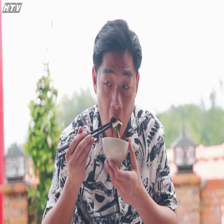

_______________________________
________________________________

🔍 Query: 'a boy who wears a green shirt prays in a church'
Test
1. Video: L27_V001 | Time: 3:03 | Score: 0.305 | File: L27_V001_03m03s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V001


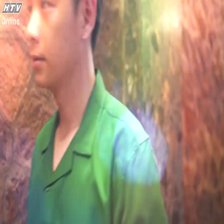

2. Video: L27_V001 | Time: 5:36 | Score: 0.285 | File: L27_V001_05m36s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V001


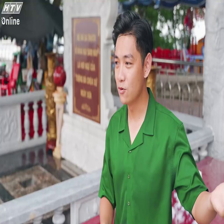

3. Video: L27_V010 | Time: 6:55 | Score: 0.285 | File: L27_V010_06m55s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V010


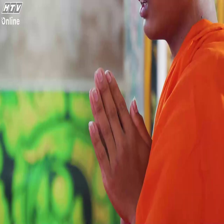

_______________________________
________________________________

🔍 Query: 'a boil of fish spicy salad'
Test
1. Video: L27_V013 | Time: 6:34 | Score: 0.314 | File: L27_V013_06m34s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V013


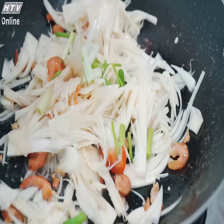

2. Video: L27_V013 | Time: 6:38 | Score: 0.308 | File: L27_V013_06m38s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V013


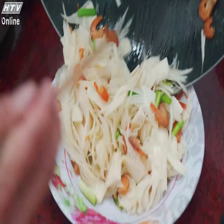

3. Video: L27_V006 | Time: 0:42 | Score: 0.304 | File: L27_V006_00m42s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V006


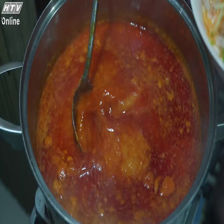

_______________________________
________________________________

🔍 Query: 'a sign that help us know where to go'
Test
1. Video: L27_V008 | Time: 3:10 | Score: 0.281 | File: L27_V008_03m10s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V008


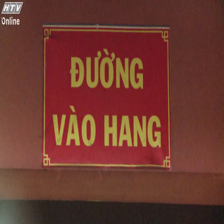

2. Video: L27_V007 | Time: 3:46 | Score: 0.273 | File: L27_V007_03m46s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V007


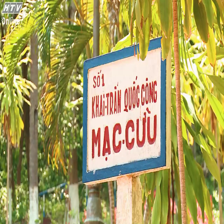

3. Video: L27_V007 | Time: 7:54 | Score: 0.271 | File: L27_V007_07m54s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V007


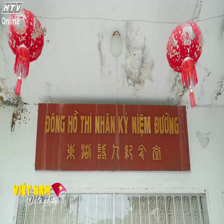

_______________________________
________________________________

🔍 Query: 'two children are playing in the coast'
Test
1. Video: L27_V008 | Time: 8:24 | Score: 0.336 | File: L27_V008_08m24s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V008


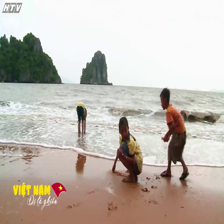

2. Video: L27_V008 | Time: 6:59 | Score: 0.307 | File: L27_V008_06m59s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V008


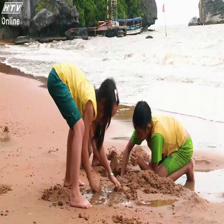

3. Video: L27_V005 | Time: 9:25 | Score: 0.304 | File: L27_V005_09m25s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V005


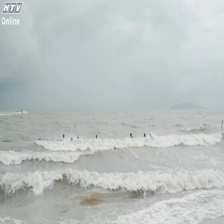

_______________________________
________________________________

🔍 Query: 'the man water the plant'
Test
1. Video: L27_V013 | Time: 4:48 | Score: 0.281 | File: L27_V013_04m48s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V013


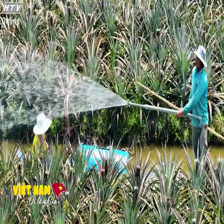

2. Video: L27_V012 | Time: 4:44 | Score: 0.268 | File: L27_V012_04m44s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V012


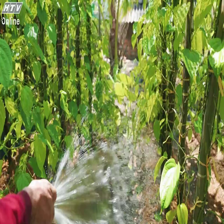

3. Video: L27_V013 | Time: 0:34 | Score: 0.268 | File: L27_V013_00m34s.jpg
/content/drive/MyDrive/DatasetKeyFrame/V013


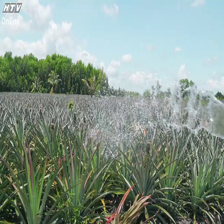

_______________________________
________________________________


In [ ]:
test_query = (
    'The man eat soup by the spoon',
    'a boy who wears a green shirt prays in a church',
    'a boil of fish spicy salad',
    'a sign that help us know where to go',
    'two children are playing in the coast',
    'the man water the plant'
)

for query in test_query:
  print(f"\n🔍 Query: '{query}'")
  res = search_keyframes(query, top_k=3)
  print("Test")


  for i, s in enumerate(res, 1):
    print(f"{i}. Video: {s['type']}_{s['video_name']} | "
              f"Time: {s['timestamp']} | "
              f"Score: {s['score']:.3f} | "
              f"File: {s['filename']}")

    key_frame_subfolder = os.path.join(keyframe_folder, s['video_name'])
    print(key_frame_subfolder)
    img = Image.open(os.path.join(key_frame_subfolder, s['filename']))
    display(img.resize((224, 224)))
  print("_______________________________\n________________________________")

In [ ]:
def search_with_filters(query_text, video_filter=None, type_filter=None, time_range=None, top_k=5):
  text_tokens = clip.tokenize([query_text]).to(device)
  with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    query_vector = text_features.cpu().numpy()[0].tolist()


  must_conditions = []
  if video_filter:
    must_conditions.append(
        models.FieldCondition(
            key='video_name',
            match=models.MatchValue(value=video_filter)
        )
    )

  if type_filter:
    must_conditions.append(
        models.FieldCondition(
            key='type',
            match=models.MatchValue(value=type_filter)
        )
    )

  if time_range:
    min_sec, max_sec = time_range
    must_conditions.append(
        models.FieldCondition(
            key='total_seconds',
            range=models.Range(
                gte=min_sec,
                lte=max_sec
            )
        )
    )

  search_filter = models.Filter(must=must_conditions) if must_conditions else None

  search_result = client.search(
      collection_name=collection_name,
      query_vector=query_vector,
      query_filter=search_filter,
      limit=top_k
  )

  results = []
  for hit in search_result:
    payload = hit.payload
    results.append({
        'type': payload['type'],
        'video_name': payload['video_name'],
        'minutes': payload['minutes'],
        'seconds': payload['seconds'],
        'timestamp': payload['timestamp'],
        'score': hit.score,
        'filename': payload['filename'],
    })

  return results

In [ ]:
info = client.get_collection(collection_name)
print(f"Collection info: {info}")

all_points = client.scroll(collection_name, limit=50000)[0]

videos = {}
labels = {}
time_ranges = []

for point in all_points:
    payload = point.payload

    # Thống kê video
    video = payload['video_name']
    videos[video] = videos.get(video, 0) + 1

    # Thống kê label
    label = payload['type']
    labels[label] = labels.get(label, 0) + 1

    # Time range
    time_ranges.append(payload['total_seconds'])

print(f"\n📊 Thống kê database:")
print(f"Tổng keyframes: {len(all_points)}")
print(f"Số videos: {len(videos)} -> {list(videos.keys())}")
print(f"Số labels: {len(labels)} -> {list(labels.keys())}")
print(f"Time range: {min(time_ranges)}s - {max(time_ranges)}s")

Collection info: status=<CollectionStatus.GREEN: 'green'> optimizer_status=<OptimizersStatusOneOf.OK: 'ok'> vectors_count=None indexed_vectors_count=0 points_count=3289 segments_count=1 config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=512, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), shard_number=None, sharding_method=None, replication_factor=None, write_consistency_factor=None, read_fan_out_factor=None, on_disk_payload=None, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=None, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=1), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), q